In [1]:
#installing required libraries
!pip install pyspark numpy pandas matplotlib seaborn scipy flask

Defaulting to user installation because normal site-packages is not writeable


In [2]:
#importing libraries

import numpy as np 
import pandas as pd 

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, col
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler

from pyspark.sql.functions import lit
from pyspark.sql.types import FloatType, IntegerType

from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import RandomForestRegressor
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew 

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
#Creating spark session
spark_session = SparkSession.builder.appName("HousingRegression").getOrCreate()
spark_context = spark_session.sparkContext
spark_sql_context = SQLContext(spark_context)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/24 16:53:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [4]:
#setting variable for csv files
TRAIN_INPUT = 'train.csv'
TEST_INPUT = 'test.csv'

In [5]:
#creating pandas dataframe
pd_train = pd.read_csv(TRAIN_INPUT)
pd_test = pd.read_csv(TEST_INPUT)
#columns with null values
na_cols = pd_train.columns[pd_train.isna().any()].tolist()
print(na_cols)

['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']


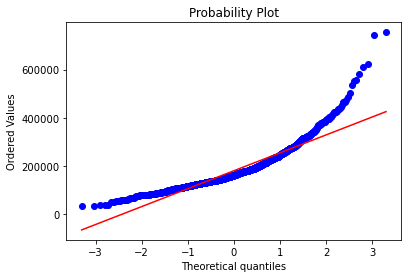

In [6]:
# how SalePrice is distributed against normal theoretical quantiles
fig = plt.figure()
ax = fig.add_subplot()
res = stats.probplot(pd_train['SalePrice'], plot=plt)

Text(0.5, 1.0, 'GarageCars vs SalePrice')

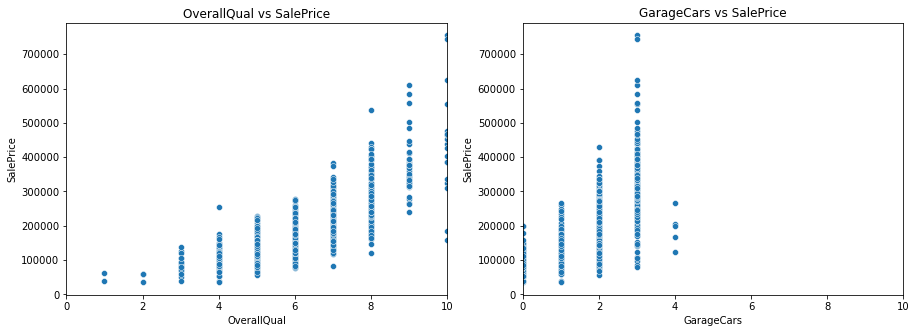

In [7]:
#plotting scatter plot
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
axes[0].set_xlim(0,10)

sns.scatterplot(data=pd_train, ax=axes[0], x='OverallQual', y='SalePrice')
axes[0].set_title('OverallQual vs SalePrice')
sns.scatterplot(data=pd_train, ax=axes[1], x='GarageCars', y='SalePrice')
axes[1].set_title('GarageCars vs SalePrice')

Text(0.5, 1.0, 'GarageArea vs SalePrice')

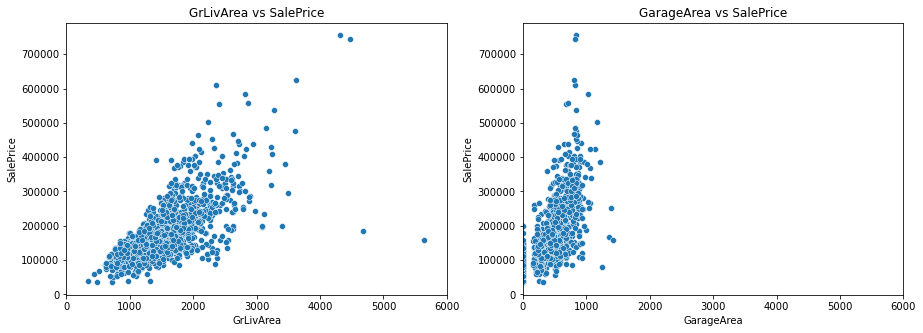

In [8]:
#plotting scatter plot
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
axes[0].set_xlim(0, 6000)

sns.scatterplot(data=pd_train, ax=axes[0], x='GrLivArea', y='SalePrice')
axes[0].set_title('GrLivArea vs SalePrice')
sns.scatterplot(data=pd_train, ax=axes[1], x='GarageArea', y='SalePrice')
axes[1].set_title('GarageArea vs SalePrice')

Text(0.5, 1.0, '1stFlrSF vs SalePrice')

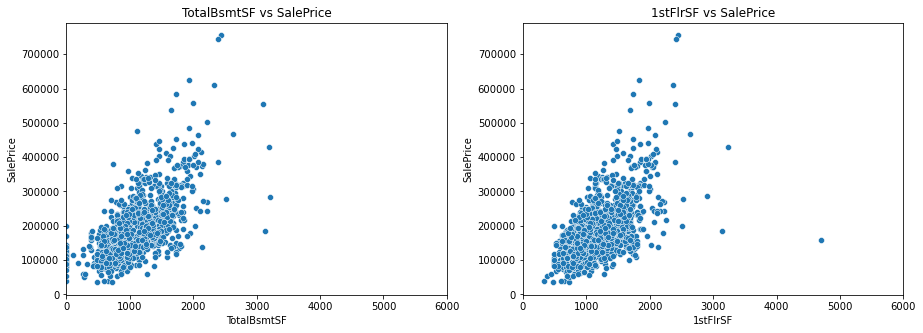

In [9]:
#plotting scatter plot
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
axes[0].set_xlim(0, 6000)

sns.scatterplot(data=pd_train, ax=axes[0], x='TotalBsmtSF', y='SalePrice')
axes[0].set_title('TotalBsmtSF vs SalePrice')
sns.scatterplot(data=pd_train, ax=axes[1], x='1stFlrSF', y='SalePrice')
axes[1].set_title('1stFlrSF vs SalePrice')

In [10]:
#calculating the total number of missing values in each column of your Pandas DataFrame pd_train and sorting them in descending order
total = pd_train.isnull().sum().sort_values(ascending=False)
#calculating the percentage of missing values in each column of your Pandas DataFrame pd_train and sorting them in descending order
percent = (pd_train.isnull().sum()/pd_train.shape[0]).sort_values(ascending=False)
#combining the total count and percentage of missing values for each column in your Pandas DataFrame pd_train into a new DataFrame named missing
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Perc_missing'])
missing.head(15)

,Total,Perc_missing
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
MasVnrType,872,0.597260
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageQual,81,0.055479
GarageFinish,81,0.055479
GarageYrBlt,81,0.055479


In [11]:
#dropping columns from your Pandas DataFrame pd_train where the percentage of missing values exceeds a threshold of  15% and removes columns with a high percentage of missing values.
pd_train = pd_train.drop(columns=(missing[missing['Perc_missing'] >= 0.15]).index)
pd_train.head()
pd_train.shape

(1460, 74)

In [12]:
#creating a new column in your Pandas DataFrame pd_train and pd_test  named 'New', and populating it with the product of the values in the 'OverallQual', 'GarageArea', and 'GrLivArea' columns.
pd_train['New'] = pd_train['OverallQual'] * pd_train['GarageArea'] * pd_train['GrLivArea']
pd_test['New'] = pd_test['OverallQual'] * pd_test['GarageArea'] * pd_test['GrLivArea']

In [13]:
#creating a list named train_cols containing the column names of your Pandas DataFrame pd_train. 
train_cols = list(pd_train.columns)
train_cols.remove('SalePrice')

In [14]:
#Make test ds feature set same as in train ds

pd_test = pd_test[train_cols]
pd_test.shape

(1459, 74)

In [15]:
#identifying columns in your Pandas DataFrame pd_test that contain missing values (NaN)
pd_test.columns[pd_test.isna().any()].tolist()

['MSZoning',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'SaleType',
 'New']

In [16]:
#handling missing values in specific columns for both training and test datasets (pd_train and pd_test and fillingit with calue "None"

for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    pd_train[col] = pd_train[col].fillna("None")
    pd_test[col] = pd_test[col].fillna("None")
    
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    pd_train[col] = pd_train[col].fillna("None")
    pd_test[col] = pd_test[col].fillna("None")
    
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    pd_train[col] = pd_train[col].fillna(0)
    pd_test[col] = pd_test[col].fillna(0)


pd_train['MasVnrArea'] = pd_train['MasVnrArea'].fillna(0)
pd_test['MasVnrArea'] = pd_test['MasVnrArea'].fillna(0)

pd_train['Electrical'] = pd_train['Electrical'].fillna(pd_train['Electrical'].mode()[0])
pd_test['Electrical'] = pd_test['Electrical'].fillna(pd_test['Electrical'].mode()[0])


In [17]:
#prints the maximum count of missing values across all columns in the dataframe
print(pd_train.isnull().sum().max()) 
print(pd_test.isnull().sum().max())

0
4


In [18]:
#filling missing values in the below columns of your Pandas DataFrame pd_test with the mean value of that column
pd_test['BsmtFinSF1'] = pd_test['BsmtFinSF1'].fillna(pd_test['BsmtFinSF1'].mean())
pd_test['BsmtFinSF2'] = pd_test['BsmtFinSF2'].fillna(pd_test['BsmtFinSF2'].mean())
pd_test['BsmtUnfSF'] = pd_test['BsmtUnfSF'].fillna(pd_test['BsmtUnfSF'].mean())
pd_test['TotalBsmtSF'] = pd_test['TotalBsmtSF'].fillna(pd_test['TotalBsmtSF'].mean())
pd_test['BsmtFullBath'] = pd_test['BsmtFullBath'].fillna(pd_test['BsmtFullBath'].mean())
pd_test['BsmtHalfBath'] = pd_test['BsmtHalfBath'].fillna(pd_test['BsmtHalfBath'].mean())

In [19]:
#column names of categorical variables (columns with data type 'object') 
cat_columns = pd_train.select_dtypes(include=['object']).columns
pd_train[cat_columns] = pd_train[cat_columns].fillna('NoData')
pd_test[cat_columns] = pd_test[cat_columns].fillna('NoData')

In [20]:
#dropping outliers from your  train dataset based on below conditions
print("Dropping outliers resulted in %d instances in the new dataset" % len(pd_train))
pd_train = pd_train.drop(pd_train[(pd_train['GrLivArea']>4500) 
                                & (pd_train['SalePrice']<300000)].index)
print("Dropping outliers resulted in %d instances in the new dataset" % len(pd_train))
pd_train = pd_train.drop(pd_train[(pd_train['GrLivArea']>5500) 
                                | (pd_train['SalePrice']>500000)].index)
print("Dropping outliers resulted in %d instances in the new dataset" % len(pd_train))
pd_train = pd_train.drop(pd_train[pd_train['GarageArea']>1100].index)
print("Dropping outliers resulted in %d instances in the new dataset" % len(pd_train))

Dropping outliers resulted in 1460 instances in the new dataset
Dropping outliers resulted in 1458 instances in the new dataset
Dropping outliers resulted in 1449 instances in the new dataset
Dropping outliers resulted in 1444 instances in the new dataset


In [21]:
#converting your Pandas DataFrames to spark dataframes
train_df = spark_session.createDataFrame(pd_train)
test_df = spark_session.createDataFrame(pd_test)

In [22]:
#selecting columns in your Spark DataFrames (train_df and test_df) based on a list of columns that contain missing values (na_cols) and removing saleprice column from list of columns and selects only the columns listed in train_cols from the test_df DataFrame.

train_df = train_df.select([c for c in train_df.columns if c not in na_cols])
train_cols = train_df.columns
train_cols.remove('SalePrice')
test_df = test_df.select(train_cols)

In [23]:

#cast below columns in your Spark DataFrame (test_df) to the IntegerType

test_df = test_df.withColumn("BsmtFinSF1", test_df["BsmtFinSF1"].cast(IntegerType()))
test_df = test_df.withColumn("BsmtFinSF2", test_df["BsmtFinSF2"].cast(IntegerType()))
test_df = test_df.withColumn("BsmtUnfSF", test_df["BsmtUnfSF"].cast(IntegerType()))
test_df = test_df.withColumn("TotalBsmtSF", test_df["TotalBsmtSF"].cast(IntegerType()))
test_df = test_df.withColumn("BsmtFullBath", test_df["BsmtFullBath"].cast(IntegerType()))
test_df = test_df.withColumn("BsmtHalfBath", test_df["BsmtHalfBath"].cast(IntegerType()))
test_df = test_df.withColumn("GarageCars", test_df["GarageCars"].cast(IntegerType()))
test_df = test_df.withColumn("GarageArea", test_df["GarageArea"].cast(IntegerType()))

In [24]:
# Defining string columns to pass on to the String Indexer (= categorical feature encoding)
#identifying columns with a data type of 'string' in Spark DataFrame train_df to list  train_string_columns
train_string_columns = []

for col, dtype in train_df.dtypes:
    if dtype == 'string':
        train_string_columns.append(col)
print(train_string_columns)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']


In [25]:
# PySpark's StringIndexer to convert categorical columns with string values into numerical indices in your Spark DataFrame train_df. 
indexers = [StringIndexer(inputCol=column, outputCol=column+'_index', handleInvalid='keep').fit(train_df) for column in train_string_columns]
pipeline = Pipeline(stages=indexers)
train_indexed = pipeline.fit(train_df).transform(train_df)

23/12/24 16:53:49 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [26]:
print(len(train_indexed.columns))

90


In [27]:
#identifying columns with a data type of 'string' in Spark DataFrame test_df to list  test_string_columns
test_string_columns = []
for col, dtype in test_df.dtypes:
    if dtype == 'string':
        test_string_columns.append(col)
print(test_string_columns)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive', 'SaleType', 'SaleCondition']


In [28]:
#PySpark's StringIndexer to convert categorical columns with string values into numerical indices in your Spark DataFrame test_df. 
indexers2 = [StringIndexer(inputCol=column, outputCol=column+'_index', handleInvalid='keep').fit(test_df) for column in test_string_columns]
pipeline2 = Pipeline(stages=indexers2)
test_indexed = pipeline2.fit(test_df).transform(test_df)

In [29]:
print(len(test_indexed.columns))

89


In [30]:
#identifying and selecting numerical columns in your Spark DataFrames (train_indexed and test_indexed)  using get_dtype function

def get_dtype(df,colname):
    return [dtype for name, dtype in df.dtypes if name == colname][0]

num_cols_train = []
for col in train_indexed.columns:
    if get_dtype(train_indexed,col) != 'string':
        num_cols_train.append(str(col))
        
num_cols_test = []
for col in test_indexed.columns:
    if get_dtype(test_indexed,col) != 'string':
        num_cols_test.append(str(col))

train_indexed = train_indexed.select(num_cols_train)
test_indexed = test_indexed.select(num_cols_test)

In [31]:
print(len(train_indexed.columns))
print(len(test_indexed.columns))

63
62


In [32]:
#PySpark's VectorAssembler to assemble the features into a single vector column features in Spark DataFrame train_indexed.
vectorAssembler = VectorAssembler(inputCols = train_indexed.drop("SalePrice").columns, outputCol = 'features').setHandleInvalid("keep")
train_vector = vectorAssembler.transform(train_indexed)

In [33]:
#PySpark's VectorAssembler to assemble the features into a single vector column features  Spark DataFrame test_indexed.
vectorAssembler2 = VectorAssembler(inputCols = test_indexed.columns, outputCol = 'features').setHandleInvalid("keep")
test_vector = vectorAssembler2.transform(test_indexed)

In [34]:
#adding a new column named "SalePrice" to your Spark DataFrame test_vector and populating it with a constant value of 0 using the lit function
test_vector = test_vector.withColumn("SalePrice", lit(0))

In [35]:
#splitting  training data (train_vector) into training and validation sets using PySpark's randomSplit methood and are stored in the train and val DataFrames.

splits = train_vector.randomSplit([0.7, 0.3])
train = splits[0]
val = splits[1]

In [36]:
# PySpark's RandomForestRegressor to train a random forest model and evaluating it on the validation set.

from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol = 'features', labelCol='SalePrice', 
                           maxDepth=20, 
                           minInstancesPerNode=2,
                           bootstrap=True
                          )

# Create a Pipeline with your model
pipeline = Pipeline(stages=[rf])

# Fit the model
rf_model = pipeline.fit(train)

# Save the model
rf_model.write().overwrite().save("model/houseprice_model")

rf_predictions = rf_model.transform(val)
rf_predictions.select("prediction","SalePrice","features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator
rf_evaluator = RegressionEvaluator(predictionCol="prediction",                  labelCol="SalePrice",metricName="r2")
print("R Squared (R2) on val data = %g" % rf_evaluator.evaluate(rf_predictions))

23/12/24 16:54:43 WARN DAGScheduler: Broadcasting large task binary with size 1248.7 KiB
23/12/24 16:54:44 WARN DAGScheduler: Broadcasting large task binary with size 1555.4 KiB
23/12/24 16:54:45 WARN DAGScheduler: Broadcasting large task binary with size 1847.5 KiB
23/12/24 16:54:47 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
23/12/24 16:54:48 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/12/24 16:54:49 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
23/12/24 16:54:49 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
23/12/24 16:54:50 WARN DAGScheduler: Broadcasting large task binary with size 2.5 MiB
23/12/24 16:54:50 WARN DAGScheduler: Broadcasting large task binary with size 2.4 MiB
23/12/24 16:54:51 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
23/12/24 16:54:51 WARN DAGScheduler: Broadcasting large task binary with size 1777.3 KiB


+------------------+---------+--------------------+
|        prediction|SalePrice|            features|
+------------------+---------+--------------------+
| 217237.3083333333|   140000|(62,[0,1,2,3,4,5,...|
|318175.74999999994|   250000|(62,[0,1,2,3,4,5,...|
|274177.55833333335|   307000|(62,[0,1,2,3,4,5,...|
|122758.08333333334|    90000|(62,[0,1,2,3,4,5,...|
| 335569.1458333334|   325300|(62,[0,1,2,3,4,5,...|
+------------------+---------+--------------------+
only showing top 5 rows

R Squared (R2) on val data = 0.910302


In [37]:
#Using RF model to make predictions on the test dataset (test_vector) and preparing the results for submission
rf_predictions2 = rf_model.transform(test_vector)
#rf_predictions2.printSchema()
pred = rf_predictions2.select("Id","prediction")
pred = pred.withColumnRenamed("prediction","SalePrice")

pred = pred.withColumn("Id", pred["Id"].cast(IntegerType()))
pred = pred.withColumn("SalePrice", pred["SalePrice"].cast(FloatType()))

In [38]:
#converting the PySpark DataFrame pred to a Pandas DataFrame (pred_pd) and then saving it to a CSV file named "submission.csv".
pred_pd = pred.toPandas()
save = pred_pd.to_csv("submission.csv", index=False)
print(pred_pd)

        Id      SalePrice
0     1461  130334.734375
1     1462  155809.671875
2     1463  175353.796875
3     1464  183447.250000
4     1465  207697.328125
...    ...            ...
1454  2915  130990.000000
1455  2916  132580.828125
1456  2917  168269.406250
1457  2918  124990.000000
1458  2919  221123.953125

[1459 rows x 2 columns]
